# DiscreteDP Example: Asset Replacement with Maintenance

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

From Miranda and Fackler, <i>Applied Computational Economics and Finance</i>, 2002,
Section 7.6.3

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from quantecon.markov import DiscreteDP

In [3]:
maxage = 5    # Maximum asset age
repcost = 75  # Replacement cost
mancost = 10  # Maintainance cost
beta = 0.9    # Discount factor
m = 3         # Number of actions; 0: keep, 1: service, 2: replace

In [4]:
# Construct the state space which is two-dimensional
s0 = np.arange(1, maxage+1)  # Possible ages
s1 = np.arange(maxage)       # Possible servicings
S = qe.cartesian([s0, s1])   # State space
n = len(S)                   # Number of states

In [5]:
S

array([[1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [2, 0],
       [2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [3, 0],
       [3, 1],
       [3, 2],
       [3, 3],
       [3, 4],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4],
       [5, 0],
       [5, 1],
       [5, 2],
       [5, 3],
       [5, 4]])

Here, in the state space we include states that are not reached
due to the constraint that the asset can be serviced at most one per year,
i.e., those pairs of the age of asset $a$ and the number of services $s$
such that $s \geq a$.

One can alternatively define the state space excluding those states;
see the section [Alternative formulation](#Alternative-formulation) below.

In [6]:
# We need a routine to get the index of a age-serv pair
def getindex(age, serv, S):
    """
    Get the index of [age, serv] in S.
    We know that elements in S are aligned in a lexicographic order.
    """
    n = len(S)
    for i in range(n):
        if S[i, 0] == age:
            for k in range(n-i):
                if S[i+k, 1] == serv:
                    return i+k

In [7]:
# Profit function as a function of the age and the number of service
def p(age, serv):
    return (1 - (age - serv)/5) * (50 - 2.5 * age - 2.5 * age**2)

In [8]:
# Reward array
R = np.empty((n, m))
R[:, 0] = p(S[:, 0], S[:, 1])
R[:, 1] = p(S[:, 0], S[:, 1]+1) - mancost
R[:, 2] = p(0, 0) - repcost

# Infeasible actions
for serv in range(maxage):
    R[getindex(maxage, serv, S), [0, 1]] = -np.inf

In [9]:
R

array([[ 36.,  35., -25.],
       [ 45.,  44., -25.],
       [ 54.,  53., -25.],
       [ 63.,  62., -25.],
       [ 72.,  71., -25.],
       [ 21.,  18., -25.],
       [ 28.,  25., -25.],
       [ 35.,  32., -25.],
       [ 42.,  39., -25.],
       [ 49.,  46., -25.],
       [  8.,   2., -25.],
       [ 12.,   6., -25.],
       [ 16.,  10., -25.],
       [ 20.,  14., -25.],
       [ 24.,  18., -25.],
       [  0., -10., -25.],
       [  0., -10., -25.],
       [  0., -10., -25.],
       [  0., -10., -25.],
       [  0., -10., -25.],
       [-inf, -inf, -25.],
       [-inf, -inf, -25.],
       [-inf, -inf, -25.],
       [-inf, -inf, -25.],
       [-inf, -inf, -25.]])

In [10]:
# (Degenerate) transition probability array
Q = np.zeros((n, m, n))
for i in range(n):
    Q[i, 0, getindex(min(S[i, 0]+1, maxage), S[i, 1], S)] = 1
    Q[i, 1, getindex(min(S[i, 0]+1, maxage), min(S[i, 1]+1, maxage-1), S)] = 1
    Q[i, 2, getindex(1, 0, S)] = 1

In [11]:
# Create a DiscreteDP
ddp = DiscreteDP(R, Q, beta)

In [12]:
# Solve the dynamic optimization problem (by policy iteration)
res = ddp.solve()

In [13]:
# Number of iterations
res.num_iter

3

In [14]:
# Optimal policy
res.sigma

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [15]:
# Optimal actions for reachable states
for i in range(n):
    if S[i, 0] > S[i, 1]:
        print(S[i], res.sigma[i])

[1 0] 1
[2 0] 0
[2 1] 1
[3 0] 2
[3 1] 0
[3 2] 0
[4 0] 2
[4 1] 2
[4 2] 2
[4 3] 2
[5 0] 2
[5 1] 2
[5 2] 2
[5 3] 2
[5 4] 2


In [16]:
# Simulate the controlled Markov chain
res.mc.state_values = S  # Set the state values
initial_state_value = [1, 0]
nyrs = 12
spath = res.mc.simulate(nyrs+1, init=initial_state_value)

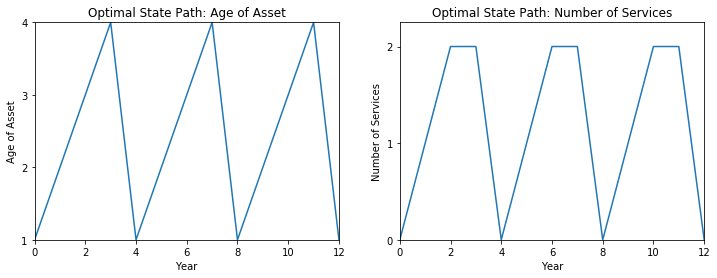

In [17]:
# Plot sample paths of the age of asset (0th coordinate of `spath`)
# and the number of services (1st coordinate of `spath`)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
captions = ['Age of Asset', 'Number of Services']
for i, caption in zip(range(2), captions):
    axes[i].plot(spath[:, i])
    axes[i].set_xlim(0, 12)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(caption)
    axes[i].set_title('Optimal State Path: ' + caption)
axes[0].set_yticks(np.linspace(1, 4, 4, endpoint=True))
axes[0].set_ylim(1, 4)
axes[1].set_yticks(np.linspace(0, 2, 3, endpoint=True))
axes[1].set_ylim(0, 2.25)
plt.show()

## Alternative formulation

Define the state space excluding the `age`-`serv` pairs that do not realize:

In [18]:
# Construct the state space which is two-dimensional
s0 = np.arange(1, maxage+1)  # Possible ages
s1 = np.arange(maxage)       # Possible servicings
S = qe.cartesian([s0, s1])   # Including infeasible pairs as previously

S = S[S[:, 0] > S[:, 1]]     # Exclude infeasible pairs
n = len(S)                   # Number of states

In [19]:
S

array([[1, 0],
       [2, 0],
       [2, 1],
       [3, 0],
       [3, 1],
       [3, 2],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [5, 0],
       [5, 1],
       [5, 2],
       [5, 3],
       [5, 4]])

We follow the state-action pairs formulation approach.

In [20]:
# Reward array
R = np.empty((n, m))
for i, (age, serv) in enumerate(S):
    R[i, 0] = p(age, serv) if age < maxage else -np.infty
    R[i, 1] = p(age, serv+1) - mancost if age < maxage else -np.infty
    R[i, 2] = p(0, 0) - repcost

In [21]:
R

array([[ 36.,  35., -25.],
       [ 21.,  18., -25.],
       [ 28.,  25., -25.],
       [  8.,   2., -25.],
       [ 12.,   6., -25.],
       [ 16.,  10., -25.],
       [  0., -10., -25.],
       [  0., -10., -25.],
       [  0., -10., -25.],
       [  0., -10., -25.],
       [-inf, -inf, -25.],
       [-inf, -inf, -25.],
       [-inf, -inf, -25.],
       [-inf, -inf, -25.],
       [-inf, -inf, -25.]])

In [22]:
# Remove the state-action pairs yielding a reward negative infinity
s_indices, a_indices = np.where(R > -np.infty)
R = R[s_indices, a_indices]

In [23]:
R

array([ 36.,  35., -25.,  21.,  18., -25.,  28.,  25., -25.,   8.,   2.,
       -25.,  12.,   6., -25.,  16.,  10., -25.,   0., -10., -25.,   0.,
       -10., -25.,   0., -10., -25.,   0., -10., -25., -25., -25., -25.,
       -25., -25.])

In [24]:
# Number of feasible state-action pairs
L = len(R)

In [25]:
# (Degenerate) transition probability array
Q = np.zeros((L, n))  # One may use a scipy.sparse matrix for a larger problem
it = np.nditer((s_indices, a_indices), flags=['c_index'])
for s, a in it:
    i = it.index
    if a == 0:
        Q[i, getindex(min(S[s, 0]+1, maxage), S[s, 1], S)] = 1
    elif a == 1:
        Q[i, getindex(min(S[s, 0]+1, maxage), min(S[s, 1]+1, maxage-1), S)] = 1
    else:
        Q[i, getindex(1, 0, S)] = 1

In [26]:
# Create a DiscreteDP
ddp = DiscreteDP(R, Q, beta, s_indices, a_indices)

In [27]:
# Solve the dynamic optimization problem (by policy iteration)
res = ddp.solve()

In [28]:
# Number of iterations
res.num_iter

3

In [29]:
# Optimal policy
res.sigma

array([1, 0, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [30]:
# Simulate the controlled Markov chain
res.mc.state_values = S  # Set the state values
initial_state_value = [1, 0]
nyrs = 12
spath = res.mc.simulate(nyrs+1, init=initial_state_value)

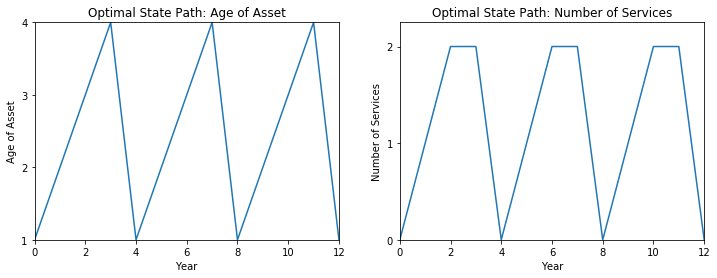

In [31]:
# Plot sample paths of the age of asset (0th coordinate of `spath`)
# and the number of services (1st coordinate of `spath`)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
captions = ['Age of Asset', 'Number of Services']
for i, caption in zip(range(2), captions):
    axes[i].plot(spath[:, i])
    axes[i].set_xlim(0, 12)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(caption)
    axes[i].set_title('Optimal State Path: ' + caption)
axes[0].set_yticks(np.linspace(1, 4, 4, endpoint=True))
axes[0].set_ylim(1, 4)
axes[1].set_yticks(np.linspace(0, 2, 3, endpoint=True))
axes[1].set_ylim(0, 2.25)
plt.show()